# AFM Simulation Code

Authors: Brendan McKiernan, Simeon Hatzopoulos

Date: 14.06.2021

In [26]:
import sys
#!{sys.executable} -m pip install py3Dmol

# Libraries needed to install to run this module (not in standard anaconda):
#conda install -c anaconda biopython
#conda install py3dmol -c conda-forge
#conda install nglview -c conda-forge

Importing / installing packages
The basic ideas in 2d
How to use it
Flow chart with each of the function and how they interact - overview of script
Understanding how each function works
Moving on / next steps


In [2]:
# Importing relevant modules
%matplotlib notebook
import numpy as np     
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image # For displaying images in Markdown
import pandas as pd #### might need to use this later
from mpl_toolkits.mplot3d import axes3d
import nglview as nv
import py3Dmol
from Bio.PDB import * #### From video: youtube.com/watch?v=mL8NPpRxgJA&ab_channel=CarlosG.Oliver
import os
import tkinter as tk
from tkinter import *

#### PDB stuff:
pdbl = PDBList()
parser = MMCIFParser()
from Bio.PDB.PDBParser import PDBParser
pdb_parser = PDBParser(PERMISSIVE=1)
from Bio.PDB import Entity
from numpy import random

In [3]:
def com_function(structure):
    
    ''' This function finds the centre of mass of each atom in the protein 
    The only input is structure, which is the PDB file.
    It returns the '''
    
    
    atom_list = structure.get_atoms() # Return atoms from residue, all atoms are unpacked.

    masses_array = []   #array of all atom masses  *empty*
    positions_array = [ [], [], [] ] #array of all positions  *empty*
    atom_pos_array = [ [], [], [] ]   #array of all atom positions  *empty*  pos: [x], [y], [z]
    
    for atom in atom_list:
        masses_array.append(atom.mass)  #creates array of all atoms masses in atom_list
        
        for i, coord in enumerate(atom.coord.tolist()):  #lists the atom coordinates and designates them a count i
            positions_array[i].append(coord) #creates an array of atom coordinates 
    
    #designating a mass to a position all three directions must be accounted for 
    for atom_index, atom_mass in enumerate(masses_array):
        atom_pos_array[0].append(positions_array[0][atom_index]*atom_mass) #x coordinates 
        atom_pos_array[1].append(positions_array[1][atom_index]*atom_mass) #y coordinates
        atom_pos_array[2].append(positions_array[2][atom_index]*atom_mass) #z coordinates
        
    return [sum(coord_list)/sum(masses_array) for coord_list in atom_pos_array]  

Data is binned to allow for AFM scanning:

In [4]:
def bin_and_label_creater(min,max,step):
    
    '''Creating bins of a certain width and their respective labels. Inputs: 
    min - minumum value (start of sample) 
    max - maximum value (end of sample)
    step - width of the bins'''
    
    delta = step #(max-min)*(1/pixels) 
    
    #creating bins between min and max in delta steps 
    bins = np.arange(min,max+delta,delta)
    
    #creating labels in the middle of each bin
    labels = np.arange(min+(delta/2),max+(delta/2),delta)

    return(bins,labels)

In [5]:
#### Let's create a 3D tip now

def threedeetipheightcalc(x,y,tip_central_x,tip_central_y,theta_in_degrees,r):
    
    '''Calculates and returns the value of height of the tip. The inputs are:
    x - a given value for x (at which the height is to be found)
    y - a given value for y (at which the height is to be found)
    tip_central_x - tip centre x position
    tip_central_y - tip cetnre y position
    theta_in_degree, r - Tip's dimensions (r is spehre radius)'''
    
    # converting theta from degrees to radians 
    theta = theta_in_degrees*(np.pi/180)
   
    # finding the gradient based on figure 6 in report 
    alpha = 1/(np.tan(theta))   # alpha is the gradient (or m)

    # creating the parameter delta in figure 6 - the distance between tip and tangent point 
    grad_del = np.sqrt(abs((r*alpha)**2/(1+alpha**2)))
    
    # the tangent point (cone meets sphere)
    X = tip_central_x + grad_del
    y_int = -np.sqrt(r**2 - grad_del**2) + r - alpha*(grad_del) #finding the y intercept - see report 
    dist_from_centre = ((x-tip_central_x)**2 + (y - tip_central_y)**2) # distance from the centre of tip
    
    z0 = y_int # should always be equal
    
    #Constructing the conical and spherical parts 
    if dist_from_centre < grad_del**2: #this would be within delta and therefore the spherical part  
        z = -np.sqrt(r**2 -(x-tip_central_x)**2 - (y-tip_central_y)**2) + r
        
    else: #else we are beyond delta at the conical part 
        c = np.tan(theta) # not equal to 1/tan(theta) bc theta is defined as angle between vertical not horizontal
        z = np.sqrt((((x-tip_central_x)**2 + (y-tip_central_y)**2)/(c**2))) + z0 
    
    return(z) #returns the height of tip


def threedeetipcreater(X,Y,tip_central_x,tip_central_y,theta_in_degrees,r):
    
    '''This function creates an array representing the height of the tip across all X and Y. Inputs:
    X - x range along which the array runs
    Y - y range along which the array runs
    tip_central_x - tip centre x position
    tip_central_y - tip cetnre y position
    theta_in_degree, r - Tip's dimensions (r is spehre radius)'''
    
    # creating an array of all heights Z
    Z= []  
    
    # For each y value a whole array off x values is created. When accumulating all y values a grid is created
    for n in range(len(Y)):  
        Z_sub_array=[]
        for i in range(len(X)): # An array of x values for each single y value
            Z_sub_array_element = threedeetipheightcalc(X[i],Y[n],tip_central_x,tip_central_y,theta_in_degrees,r)
            Z_sub_array.append(Z_sub_array_element)
        Z.append(Z_sub_array) # create an array with height at certain x and y coordinates
    Z_array = np.array(Z) 
    
    return(Z_array) #return all heights across X by Y grid

<IPython.core.display.Javascript object>


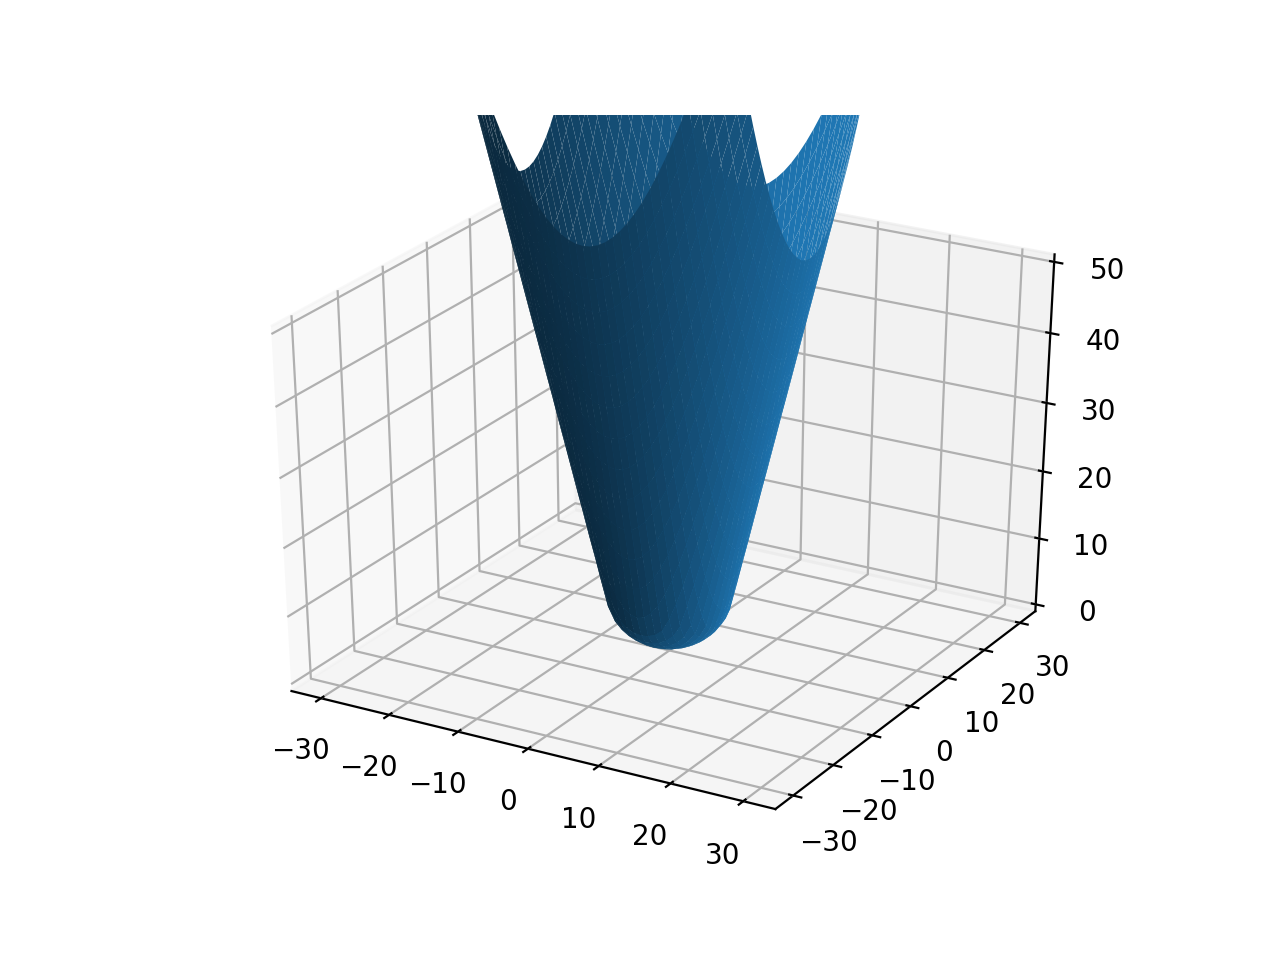

In [6]:
### Illustrating the tip
fig = plt.figure()
ax = fig.add_subplot(projection='3d')  #prev:   fig.add_subplot(111, projection='3d')

i = 20
x = np.arange(-i,i,1)
y = np.arange(-i,i,1)

X, Y = np.meshgrid(x, y)
Z = threedeetipcreater(x,y,0,0,12,8)
ax.plot_surface(X,Y,Z, rstride = 1, cstride = 1)

#chaning axes proportion to depict an accurate tip
s = 30
ax.auto_scale_xyz([-s, s], [-s, s], [0, 50])

In [7]:
def df_from_structure(structure,x_rot,y_rot,z_rot,view_style):
    
    
    t0 = time.time()
    
    '''This function  produces a dataframe with the XYZ coordinates of each
    atom and automatically adjust the Z values so the minimum Z value equals zero. Inputs:
    structue of the PDB file 
    The user's x-axis, y-axis and z-axis rotation angles 
    The view style...'''
    
    
    # Creating rotation matrices according to user input 
    null_rotation_matrix = rotaxis2m(0, Vector(0,0,1))  #BioPython command to rotate around axis m
    rotation_matrix = rotaxis2m(x_rot*(np.pi/180), Vector(1,0,0)) # convert to radians 
    rotation_matrix_2 = rotaxis2m(z_rot*(np.pi/180), Vector(0,0,1))
    rotation_matrix_3 = rotaxis2m(y_rot*(np.pi/180), Vector(0,1,0))
    
    if len(structure) == 1: 
        #retrieving atoms, the centre of mass and its position
        atoms = structure.get_atoms() #BioPython: structure.get --> position of atoms
        com = com_function(structure) #finding the centre of mass using previous function
        mean_x, mean_y, mean_z = com[0],com[1],com[2] #poistion of centre of mass

        ###### Not quite sure ######
        translation_matrix = np.array((0, 0, 0), 'f')
        true_translation_matrix = np.array((-mean_x, -mean_y, -mean_z), 'f')  

        #creating coordinate arrays 
        x_coord_array=[]
        y_coord_array=[]
        z_coord_array=[]

        #Transforming the protein to the user's preferred starting orientation
        for atom in atoms:
            atom.transform(null_rotation_matrix, true_translation_matrix)  #applies the matrices to each atom 
            atom.transform(rotation_matrix,translation_matrix) 
            atom.transform(rotation_matrix_2, translation_matrix)
            atom.transform(rotation_matrix_3, translation_matrix)

            x = atom.get_coord()[0]  #Returns atomic coordinates for x
            y = atom.get_coord()[1]  #Returns atomic coordinates for y
            z = atom.get_coord()[2]  #Returns atomic coordinates for z

            # New set of coordnates for User's orientation
            x_coord_array.append(-x) 
            y_coord_array.append(-y)
            z_coord_array.append(-z)

        # Transposing the tip (either up or down) accoring to the minium displacement - see report 
        z_min = np.min(z_coord_array) #finding minimum displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_coord_array)) #creates an array with only -z terms 
        final_z_coord_array = np.add(z_coord_array,z_adjust_array) #this array is subtracted from z to shift the tip down

        sample_height_max = np.max(final_z_coord_array) #why max?

        # Creating a dataframe for x y and z coordinates (in one set)
        d = {'X': x_coord_array, 'Y': y_coord_array, 'Z': final_z_coord_array} 
        df = pd.DataFrame(data=d) # produces correct data frame

        #viewing the protein
        post_adj_view = nv.show_biopython(structure)
        post_adj_view.add_representation(view_style, selection='protein')

        ### Returning Structure to original rotation (if confused query me via email: brendan.mckiernan.17@ucl.ac.uk)
        atoms = structure.get_atoms()
        com = com_function(structure)
        mean_x, mean_y, mean_z = com[0],com[1],com[2]

        #resets the protein to its orignal position: Now user can enter a different orientation
        null_rotation_matrix = rotaxis2m(0, Vector(0,0,1))
        rotation_matrix = rotaxis2m(-x_rot*(np.pi/180), Vector(1,0,0)) #opposite to matrices above
        rotation_matrix_2 = rotaxis2m(-z_rot*(np.pi/180), Vector(0,0,1)) #resets previous rotations
        rotation_matrix_3 = rotaxis2m(-y_rot*(np.pi/180), Vector(0,1,0))
        translation_matrix = np.array((0, 0, 0), 'f')
        true_translation_matrix = np.array((-mean_x, -mean_y, -mean_z), 'f')  

        for atom in atoms:
            atom.transform(rotation_matrix_3,translation_matrix)
            atom.transform(rotation_matrix_2, translation_matrix)
            atom.transform(rotation_matrix, translation_matrix)
        

    elif type(structure1) is tuple:
    #user must input x, y and z coordinate arrays  
        #unpacking array
        x1 = structure1[0]
        y1 = structure1[1]
        z1 = structure1[2]
        
        #flattening 
        x_flat = x1.flatten()
        y_flat = y1.flatten()
        z_flat = z1.flatten()

         # Transposing the tip (either up or down) accoring to the minium displacement - see report 
        z_min = np.min(z_flat) #finding minimum displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_flat)) #creates an array with only -z terms 
        final_z_flat = np.add(z_flat,z_adjust_array) #this array is subtracted from z to shift the tip down

        sample_height_max = np.max(final_z_flat) #why max?
                                   
        d = {'X': x_flat, 'Y': y_flat, 'Z': final_z_flat} 
        df = pd.DataFrame(data=d) # produces correct data frame
        
        post_adj_view = 0 
        #post_adj_view = ax.plot_surface(x1, y1, z1, cmap=plt.cm.YlGnBu_r)
        #post_adj_view.add_representation(view_style, selection='protein')
        
        #print(df)
        
    else:
        
        #Data1 = pd.read_csv('Data_array.csv', index_col=False)
        
        x1, y1, z1 = structure1.T.values
        
        #flattening 
        x_flat = x1.flatten()
        y_flat = y1.flatten()
        z_flat = z1.flatten()

         # Transposing the tip (either up or down) accoring to the minium displacement - see report 
        z_min = np.min(z_flat) #finding minimum displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_flat)) #creates an array with only -z terms 
        final_z_flat = np.add(z_flat,z_adjust_array) #this array is subtracted from z to shift the tip down

        sample_height_max = np.max(final_z_flat) #why max?
                                   
        d = {'X': x_flat, 'Y': y_flat, 'Z': final_z_flat} 
        df = pd.DataFrame(data=d) # produces correct data frame
        
        post_adj_view = 0
        #post_adj_view = ax.plot_surface(x1, y1, final_z_flat, cmap=plt.cm.YlGnBu_r)
        #post_adj_view.add_representation(view_style, selection='protein')
        
    t1 = time.time()
    #t_dffstr = t1- t0
    print("df_from_structure", t1 - t0)
    
    return(df, sample_height_max, post_adj_view) #returns data frame, max height and views the protein

In [35]:
##### Making a function for taking structure, zeroing and putting into a binned dataframe:

    

def structure_data_extracter(structure,xstep,ystep,extension,x_rot,y_rot,z_rot,view_style):
    
    t0 = time.time()
    
    '''This function takes the structure and cuts it into bins. Inputs are:
    structue of the PDB file 
    xstep and ystep - of the bins
    extension - size of the stage on which the protein sits
    The user's x-axis, y-axis and z-axis rotation angles 
    The view style...'''
    
    #Using the previous function to create the dataframe we wish to work with (including orientation)
    #take structure and zero, put into dataframe
    new_df, sample_height_max, post_adj_view = df_from_structure(structure,x_rot,y_rot,z_rot,view_style) 
    
    # finding the maximums and minimums for x and y in this data frame
    Y_max, Y_min = new_df['Y'].max(), new_df['Y'].min() #function extracting max and min 
    X_max, X_min = new_df['X'].max(), new_df['X'].min()
    
    # creating the bins (and labels) using the bin and label creator function 
    Xbins,Xlabels= bin_and_label_creater(X_min-extension,X_max+extension,xstep)
    Ybins,Ylabels= bin_and_label_creater(Y_min-extension,Y_max+extension,ystep)
    
    #pd.cut takes a continuous data set and cuts and sorts it into bins:
    new_df['Binned_Y'] = pd.cut(new_df['Y'], Ybins, right = False, labels = Ylabels) 
    new_df['Binned_X'] = pd.cut(new_df['X'], Xbins, right = False, labels = Xlabels)
    
    sorted_bdf = new_df.sort_values('Binned_X') #sorting the bins for X

    #zeroing the data and dropping values that are not needed - only height is important 
    reduced_col_bdf = sorted_bdf.drop(columns = ['X','Y']) #dropping X and Y - no longer needed 
    reduced_sorted_bdf = reduced_col_bdf.groupby(['Binned_X','Binned_Y'])['Z'].max() #taking the max z values 
    reduced_sorted_bdf_filled = reduced_sorted_bdf.replace(np.nan, 0.0) #nan - 'not a number' replaced with 0
    
    t1 = time.time()
    print(t1-t0)
    
    return(reduced_sorted_bdf_filled,Xlabels,Ylabels,new_df,sample_height_max,post_adj_view)

In [36]:
##### creating a 3D Tip Height Calculator:

def height_diff_calc_three_dee(Xlabels,Ylabels,reduced_sorted_bdf_filled,tip_central_x,tip_central_y,theta_in_degrees,r):
    
    '''This function calculates the adjustment to the height of the tip, based on the tip's steric
    interaction with the structure. Inputs are: 
    Xlables, Ylables - created by the `structure_data_extracter`
    reduced_sorted_bdf_filled - the binned date frame
    the tip position and dimenstion (theta and r)'''
      
    #Again a grid of values for Y and X is created, this time for the binned data
    
    Z= []
    for n in range(len(Ylabels)): #array for Ylabels 
        Z_sub_array=[]  
        for i in range(len(Xlabels)):  
            Z_sub_array_element = reduced_sorted_bdf_filled[i*len(Ylabels)+n] #array of Xlables for each Ylabel  
            Z_sub_array.append(Z_sub_array_element)  
        Z.append(Z_sub_array)  
    Z_array = np.array(Z) #creating an array for heights Z in binned data   
    
    #Z_array = np.meshgrid(Ylabels, reduced_sorted_bdf_filled, copy=True, sparse=False, indexing='xy')
       
    #creating a tip for this particular binned data frame 
    Z_tip = threedeetipcreater(Xlabels,Ylabels,tip_central_x,tip_central_y,theta_in_degrees,r)
    
    #Finding the displacement of the tip and correcting it - AFM measuring 
    height_delta = Z_tip - Z_array #difference between data and tip
    min_delta = np.min(height_delta) #finding miminum distance 
    corrected_height_delta = (-1)*min_delta #subtracting the minimum difference 
    
    return(corrected_height_delta) #returns the new height of tip

In [10]:
def error_signal(x,setpoint,arb,n,grad): #what is arb?
    
    '''Calculates the error signal for the feedback mechanics based on the 
    difference between the setpoint height and the hight of probe. Inputs:
    x - position 
    setpoint - the height at wich the tip begins 
    arb - arbitrary number after which the feedback mechanism doesn't increase 
    grad - gradient of error graph (see report)'''
    
    # creating a linear error graph up to a point where the error stays constant (no effect on tip)
    if x > (setpoint+arb):
        error_value = -grad*(arb)  #linear relationship when z is below the setpoint 
        
    else :
        error_value = -grad*(x-setpoint) #no effect (horizontal line) when z is above the setpoint 
             
    return(error_value)  #returns the value at a certain position x


### Now the feedback must be calculated 
def feedback2d(scanline,setpoint,arb,KP_eff,KI,n,grad):
    
    '''Applies the feedback mechanism to a scanline and calculates the error signal at each point.
    The strength of feedback is based on the values of KP & KI. Inputs:
    scanline - The array of postions coordinattes to be scanned 
    setpoint - the height at wich the tip begins
    KP_eff, KI - feedback coefficients
    grad - gradient of error graph (see report)'''
    
    #initial conditions for while loop and scanline
    i = 0
    feedbacked_image = [scanline[0]]
    delta_height_array = [] #height of probe
    error_array = []
    
    
    while i < (len(scanline) - 1):
        
        #For each point a difference in the height of the tip and the sample (scanline) is found 
        #this difference is tells the feedback mechanism to move the tip up or down 
        
        delta_height = (feedbacked_image[i] - scanline[i]) # the difference between probe and scanline
        delta_height_array.append(delta_height) #added to height array
        
        #creating an error curve for each point 
        error = error_signal(delta_height,setpoint,arb,n,grad) #using function from above 
        error_array.append(error)
        
        #finally calculating the feedback using foruma from report
        feedback = KP_eff*error + KI*np.mean(error_array)  #using error coefficients 
        feedbacked_image.append(feedbacked_image[i] + feedback) #feedback is added to the scanline

        i = i + 1 
    
    return(feedbacked_image) #new coordinates of scanline 

<IPython.core.display.Javascript object>


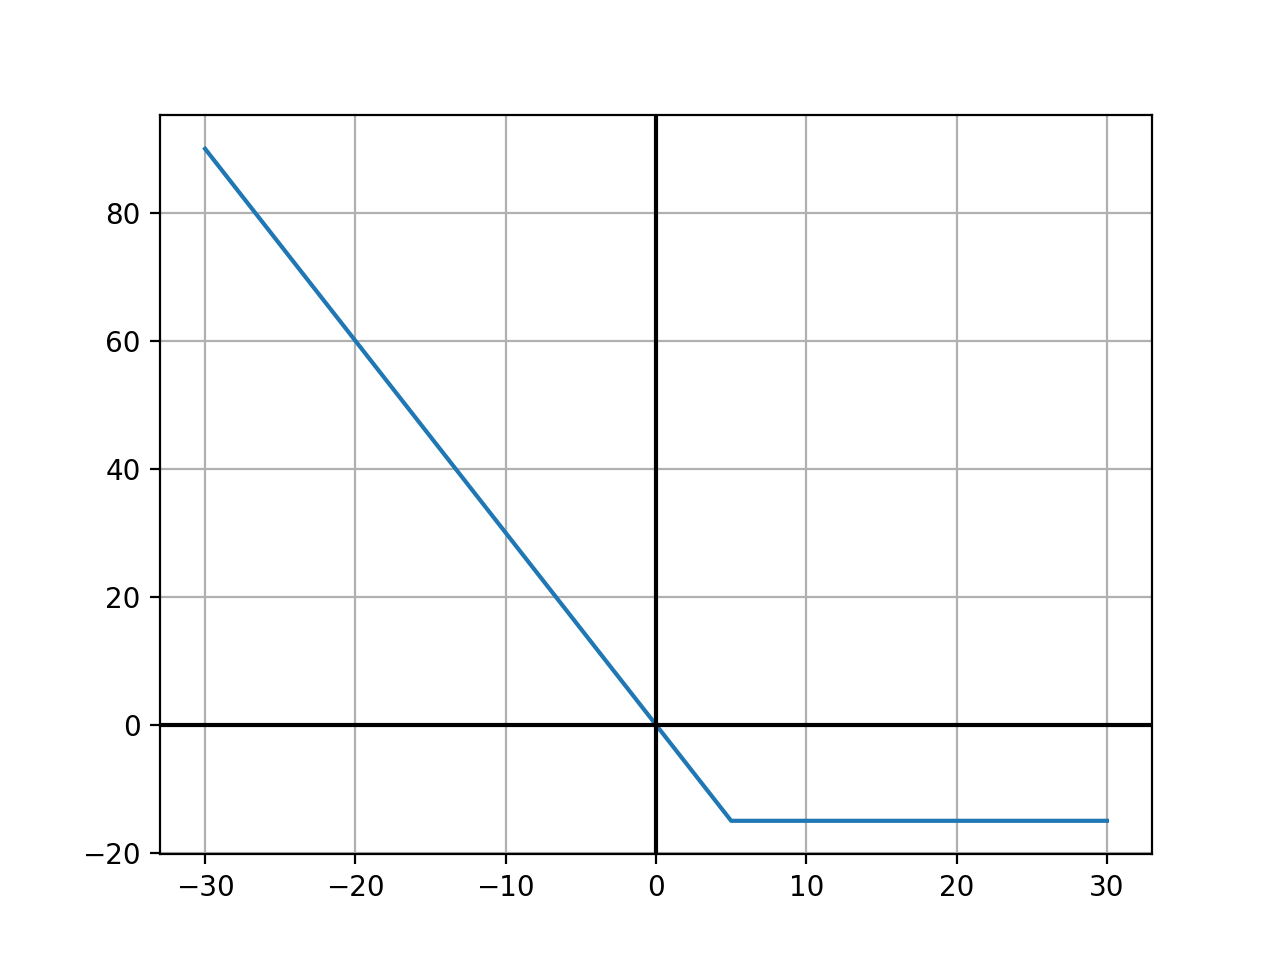

In [11]:
# Illustration of error signal, displacement relationship - TEST CELL

#setting conditions - TEST
arb_trial = 5
setpoint_trial = 0
power = 1
grad = 3

#creating array of plotted values 
feedback_values = []

#creating an error signal to plot 
n = -30
i = n
while i <= (-n):
    feedback_val = error_signal(i,setpoint_trial,arb_trial,power,grad)
    feedback_values.append(feedback_val)
    i = i + 1
    
#Plotting figure 
fig, ax = plt.subplots()
ax.plot(np.arange(n,-(n-1),1),feedback_values,'-')
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

In [12]:
def height_image_producer(Xlabels,Ylabels,reduced_sorted_bdf_filled,theta_in_degrees,r,noise_strength,
                          noise_mean,noise_variance,setpoint,arb,KP_eff,KI,n,grad,scanline_direction,Feedbacked):
    
    '''Produces an array representing height of the sample across all x and y. The two outputs are:
    height based on steric collision model (with noise) and height based on feedback mechanism. Inputs:
    Xlables, Ylables - grid of bins created by the `structure_data_extracter`
    reduced_sorted_bdf_filled - the binned date frame
    the tip position and dimenstion (theta and r)
    Noise - strenght, mean and variance 
    setpoint - initial height of tip
    KP_eff, KI - feedback coefficients
    grad - gradient of error graph (see report)'''
    
    #setting up arrays
    H= [] #initial array for steric collision model
    H2=[] #initial array for feedback mechanism
    
    #creating a grid 
    for n in range(len(Ylabels)):
        H_sub_array=[]  # Each H_sub_array is effectively a scanline at a given value of Y
        
        for i in range(len(Xlabels)):
            
            #Calculating the height difference using functions above:
            H_sub_array_element = height_diff_calc_three_dee(Xlabels,Ylabels,reduced_sorted_bdf_filled,
                                                             Xlabels[i],Ylabels[n],theta_in_degrees,r)
            H_sub_array.append(H_sub_array_element)
            
            
        # Adding in noise to each scanline:
        noise_array = noise_strength*random.normal(noise_mean,noise_variance,size=len(H_sub_array))  #Gaussian    
        H_sub_array_with_noise = H_sub_array + noise_array #aimply adding noise to sample
        
        
        #### Now considering scanning Right to Left:
        
        # Different noise on second scan back
        new_noise_array = noise_strength*random.normal(noise_mean,noise_variance,size=len(H_sub_array)) 
        reverse_H_sub_array = H_sub_array[::-1] #the new array is reversed but the code stays the same
        reverse_H_sub_array_with_noise = reverse_H_sub_array + new_noise_array
        
        if Feedbacked == True:
        
            # Adding in Feedback to each scanline:
            H_sub_array_with_noise_and_feedback = feedback2d(H_sub_array_with_noise,setpoint,arb,KP_eff,KI,n,grad)
            reverse_scanline_H_sub_array = feedback2d(reverse_H_sub_array_with_noise, setpoint,arb,KP_eff,KI,n,grad)[::-1]

        
        else:
            H_sub_array_with_noise_and_feedback = 0
            reverse_scanline_H_sub_array = 0

        ##### Merging both feedback lines:
        H_sub_array_both_directions = (1/2)*(np.array(H_sub_array_with_noise_and_feedback) \
                                             + np.array(reverse_scanline_H_sub_array))     

            
        #### Merging both scanlines with noise:
        
        H_sub_array_with_noise_both_directions = (1/2)*(H_sub_array_with_noise + reverse_H_sub_array_with_noise)
        H.append(H_sub_array_with_noise)
        
        #assigning the arrays to an appropriate designation
        if scanline_direction == 'left_to_right':
            H2.append(H_sub_array_with_noise_and_feedback)
                        
        if scanline_direction == 'right_to_left':
            H2.append(reverse_scanline_H_sub_array)
                    
        if scanline_direction == 'both':
            H2.append(H_sub_array_both_directions)
                   
    H_array = np.array(H) #height based on steric collision model
    H2 = np.array(H2) #height based on feedback mechanism 
    
    return(H_array,H2) #outputs both methods

In [37]:
@profile
def psuedo_AFM_image_producer(structure, r, theta_in_degrees, xstep, ystep, extension, x_rot, y_rot, z_rot, 
                              noise_strength,noise_mean,noise_variance,setpoint,arb,KP_eff,KI,n,grad,
                              scanline_direction,ThreeDplot, Heatmap,Feedbacked,molecule_view, view_style,
                              Simulated_Surface,DotPlot,Overlay_Plot,relative_contrast,feedback_graph):
    
    '''Final function which brings everything together. User inputs all variables and all results 
    are outputted. The user gets a feedback plot of the error values, A heatmap of the AFM image,
    and 3D plots of the sample surface. Inputs are:
    ALL INPUTS MENTIONED IN FUNCTIONS ABOVE'''
    
    #First the data is extracted from the PDB file using function
    structure_df_check,Xlabels,Ylabels,new_df,sample_height_max,post_adj_view = structure_data_extracter(structure,xstep,ystep,
                                                                                                         extension, x_rot,
                                                                                                         y_rot,z_rot, view_style)
    #now the height of the tip at all points is being found 
    Z_AFM, feedbacked_H = height_image_producer(Xlabels,Ylabels,structure_df_check,theta_in_degrees,
                                                r,noise_strength,noise_mean,noise_variance,setpoint,
                                                arb,KP_eff,KI,n,grad,scanline_direction,Feedbacked)
    
    
    #### Depending what the user needs - Heatmap with feedback and noise
    if Feedbacked == True:
        
        #plotting AFM with feedback + noise
        fig=plt.figure()
        fig.suptitle('AFM image w/feedback + noise', fontsize=16)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
                ### This section is for adjusting the contrast in colour map image ###
        feedbacked_H_range = feedbacked_H.max()-feedbacked_H.min()
        vmin_value = feedbacked_H_range * relative_contrast
        plt.contourf(X,Y,feedbacked_H,levels=100, cmap='afmhot', vmin = vmin_value) #creating contours
        plt.colorbar()
    
    
    #### A heatmap of the AFM image is a good visual tool, so it will be included 
    if Heatmap == True:
        
        #plotting heatmap without feedback
        fig = plt.figure()
        fig.suptitle(' AFM image, no feedback ')      
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
                ### This section is for adjusting the contrast in colour map image ###
        Z_AFM_range = Z_AFM.max()-Z_AFM.min()
        vmin_value = Z_AFM_range * relative_contrast
        plt.contourf(X,Y,Z_AFM,levels=100, cmap='afmhot', vmin = vmin_value) #creating contours - as above
        plt.colorbar()
          
            
    #### 3D plot of sample
    if ThreeDplot == True:
        
        #plotting a 3d plot withno feedback
        fig=plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.suptitle('Three dimensional plot of AFM image (no feedback)')
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        ax.plot_surface(X,Y,Z_AFM, rstride = 1, cstride = 1) #plotting Z_AFM on top of X and Y plane
     
    
    ####
    if Simulated_Surface == True:
        
        Z= []
        for n in range(len(Ylabels)):
            Z_sub_array=[]
            for i in range(len(Xlabels)):
                Z_sub_array_element = structure_df_check[i*len(Ylabels)+n]
                Z_sub_array.append(Z_sub_array_element)
            Z.append(Z_sub_array)

        Z_array = np.array(Z)
        fig=plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        ax.plot_surface(X,Y,Z_array, rstride = 1, cstride = 1)
        
        
    #### Dot plot of atoms in the protein
    if DotPlot == True:
        
        #plotting a dotlpot 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        #new data frame of binned atoms 
        X = new_df['X']
        Y = new_df['Y']
        Z = new_df['Z']

        #scatter plot of all coordinate pairs
        ax.scatter(X,Y,Z, marker='.' ,alpha=0.6,color='r', cmap='viridis')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
        plt.show()
        s = 30
        ax.auto_scale_xyz([-s, s], [-s, s], [0, 50])
        
        
    #### The dot plot and the 3D surface will be overlayed for comparison
    if Overlay_Plot == True:
        
        # setting up the plot and axes 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X = new_df['X']
        Y = new_df['Y']
        Z = new_df['Z']

        #plotting the scatter of atoms 
        ax.scatter(X,Y,Z, marker='.' ,alpha=0.6,color='r', cmap='viridis') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
        
        #repeating code for plotting the surface 
        Z= []
        for n in range(len(Ylabels)):
            Z_sub_array=[]
            for i in range(len(Xlabels)):
                Z_sub_array_element = structure_df_check[i*len(Ylabels)+n]
                Z_sub_array.append(Z_sub_array_element)
            Z.append(Z_sub_array)

        #all together on the grid
        Z_array = np.array(Z)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
        #setting up and labelling axes
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        
        #plttong surface
        ax.plot_surface(X,Y,Z_array, rstride = 1, cstride = 1, alpha = 0.65)
    
    
    #### Feedback/error graph of the sample
    if feedback_graph == True:
        
        #collecting feedback values 
        feedback_values = []

        #setting up initial conditions
        n = -30 #n is the range in x 
        i = n
        while i <= (-n):
            feedback_val = error_signal(i,setpoint,arb,n,grad) #using function defined above
            feedback_values.append(feedback_val)
            i = i + 1

        #plotting the linear graph
        fig, ax = plt.subplots()
        ax.plot(np.arange(n,-(n-1),1),feedback_values,'-')
        ax.grid(True, which='both')
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='k')
        
    #### 
    if molecule_view == True:
        return(post_adj_view)
    
#plotting everything
plt.show()

In [14]:
def PDB_getter(structure_name):
    
    '''This function imports the relevant PDB file (and takes care of the directory) 
    in which it is saved etc for the user, returning the structure and the view using a widget.
    The only input is the name of the PDB file (four letters)'''

    #command to get four letter PDB file using Bio.Python
    pdbl.retrieve_pdb_file(structure_name)
    
    #creating a folder on the Users system - location is the same as the Notebook file's
    split_structure_name = list(structure_name)
    structure_file_folder = str(split_structure_name[1]) + str(split_structure_name[2])
    c ='.cif' #filetype prefix.
    the_slashes = '/' #compatible with MAC not WINDOWS. for WINDOWS use: '\\'
    d = 'pdb:' 
    directory = str(os.getcwd())
    
    #retrieving file from the location it was just saved in
    file_loc = directory + the_slashes + structure_file_folder + the_slashes + structure_name + c
    structure = parser.get_structure(structure_name, file_loc)  # defining structure, 'name we give it' and 'location'
    viewer_name = d + structure_name
    
    #plotting the relevant structure using py3Dmol 
    view = py3Dmol.view(query=viewer_name).setStyle({'cartoon':{'color':'spectrum'}})
    
    return(structure,view) #returns the structure (input for other functions) and views the protein

## Inputs & Outputs:


Here the user has two choice. They can choose to insert a PDB file (recommended) by either importing it from their device or by insterting the four digit code corresponding to their desired protein. They can also choose to image any three-dimensional shape. To do this the user needs to first create this shape through any means that outputs coordinate arrays for x, y and z. These, must then be constructed as an array named as structure1.

In [20]:
#### USER INPUT SECTION ####

#Ask the user if they want to input a CSV or a PDB file

manual = input('would you like to import a PDB (type "pdb") file or a CSV file (type "csv")')
#User is asked to choose between a manual PDB file input or the four character code from the database

if manual == 'csv':
    
    csv_loc = input('please input the location of your csv file:')
    structure_name = input('Please assign a name to this structure: ')
    print('Please proceed to load the viewer')
    
if manual == 'pdb':

    manual = input('Would you like to manually upload a pdb file (enter yes), or input the 4-digit PDB name (enter no):') 

    #PDB four-character code input
    if manual == 'no': 
        four_digit = False

        #User interaction to enter PDB code 
        structure_name = input('Please input the 4-digit name of the protein you would like to use:')

        #making sure the input string has four characters
        while four_digit == False:
            if len(structure_name) != 4:
                print('ERROR, the name you have entered is not 4-digits, please enter a new one:') 
                structure_name = input('Please input the 4-digit name of the protein you would like to use:')
            else:
                four_digit = True 
                print('You have entered a four-digit name, please proceed to load the viewer') 
                
    #Manual entry
    
    if manual == 'yes':

        #User is now asked to insert file location of where the PDB file is located
        structure_name = input('Please assign a name to this structure: ')
        file_loc = input('Please input the file location: ')

else:
    print('The input is not in the correct format, please try again.')
    
    
    #else:
    #    print('You have not input either "yes" (to manually upload a PDB) or "no" (to load the PDB via its name), PLEASE RE-RUN THIS CELL')

would you like to import a PDB (type "pdb") file or a CSV file (type "csv")csv
please input the location of your csv file:football.csv
Please assign a name to this structure: hi
Please proceed to load the viewer
The input is not in the correct format, please try again.


In [21]:
%%capture  
## Adding the above hides all the error messages from the cell

#get PDB files usinf function above 
if manual == 'csv':
    
    allcoord = np.loadtxt(csv_loc, delimiter=',')
    all_flat = allcoord.flatten(order='A')

    X_all = all_flat[0::3]
    Y_all = all_flat[1::3]
    Z_all = all_flat[2::3]

    structure1 = (X_all, Y_all, Z_all)

if manual == 'no':
    structure1,view = PDB_getter(structure_name)

#user inputs location and structure name 
if manual == 'yes':
    structure1 = pdb_parser.get_structure(structure_name, file_loc)  

else:
    print ('please re-run the previous cell')

In [22]:
new_view = nv.show_biopython(structure1)
new_view

### Issue with y axis flip apparent here

AttributeError: 'tuple' object has no attribute 'level'

In [23]:
#setting up the view 
new_view.clear_representations()
new_view.add_representation('spacefill', selection='protein')

NameError: name 'new_view' is not defined

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

df_from_structure 0.003017902374267578
0.033651113510131836


<IPython.core.display.Javascript object>


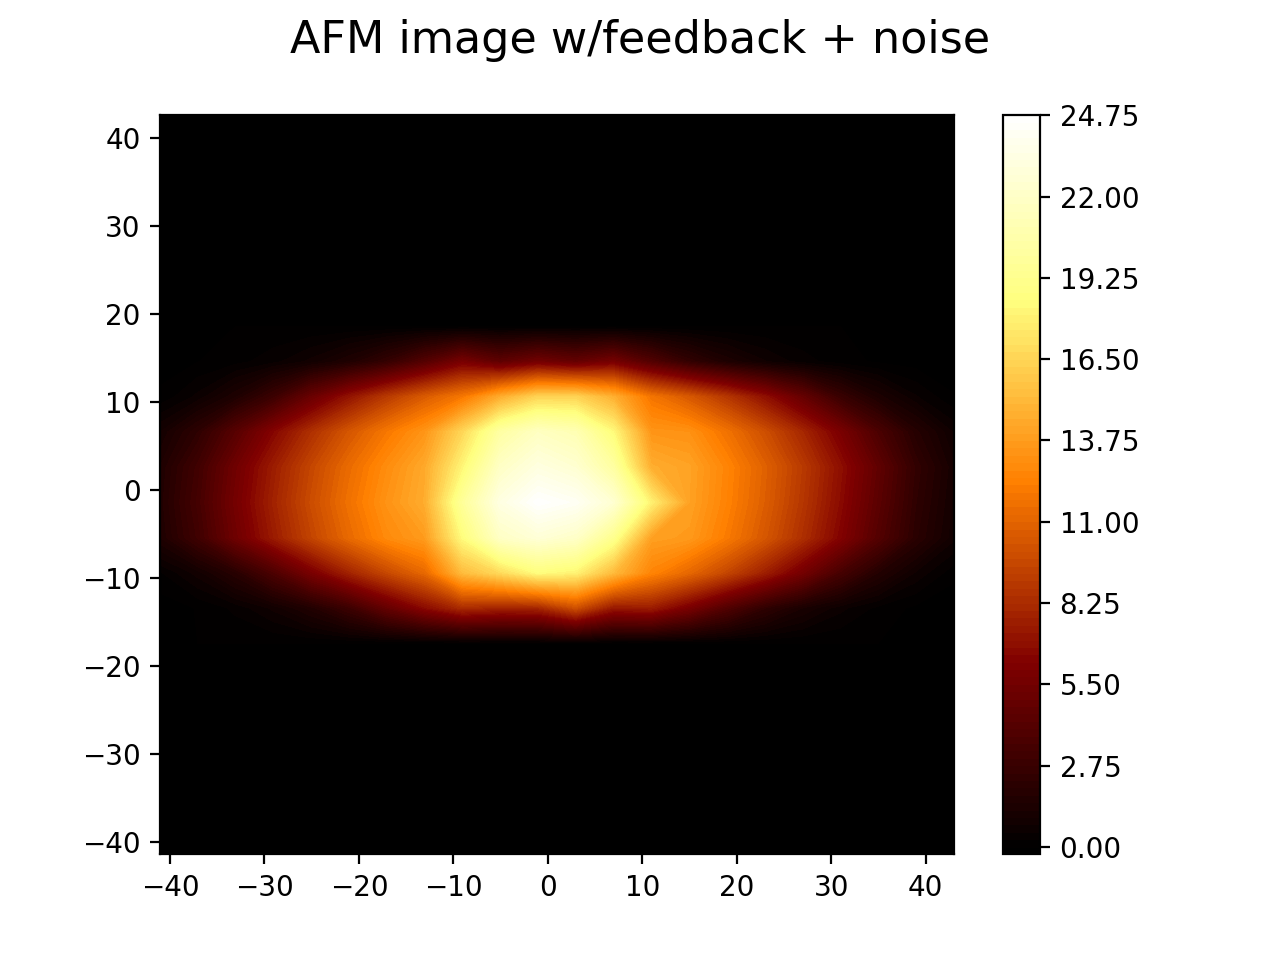

<IPython.core.display.Javascript object>


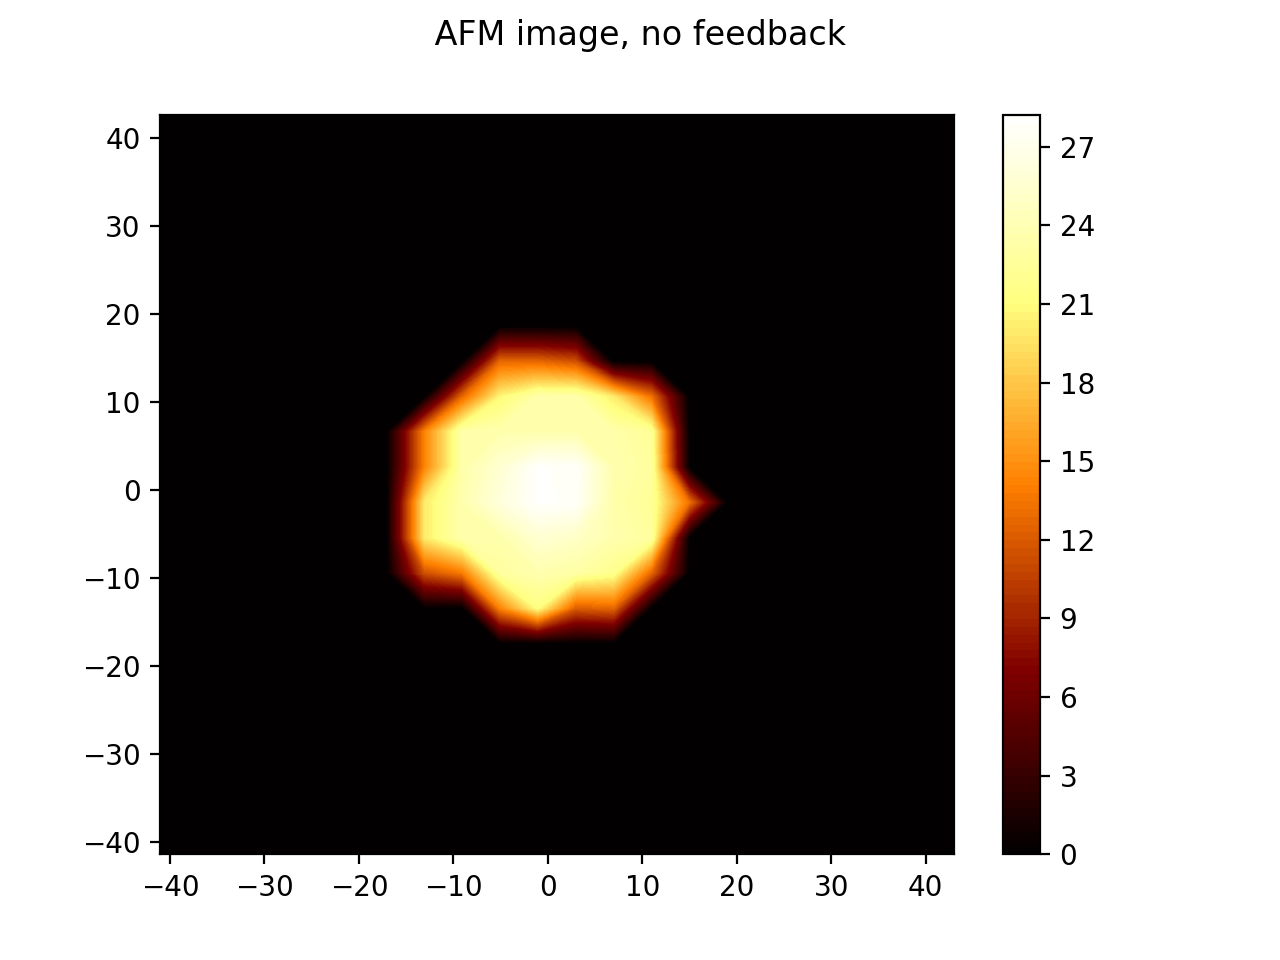

<IPython.core.display.Javascript object>


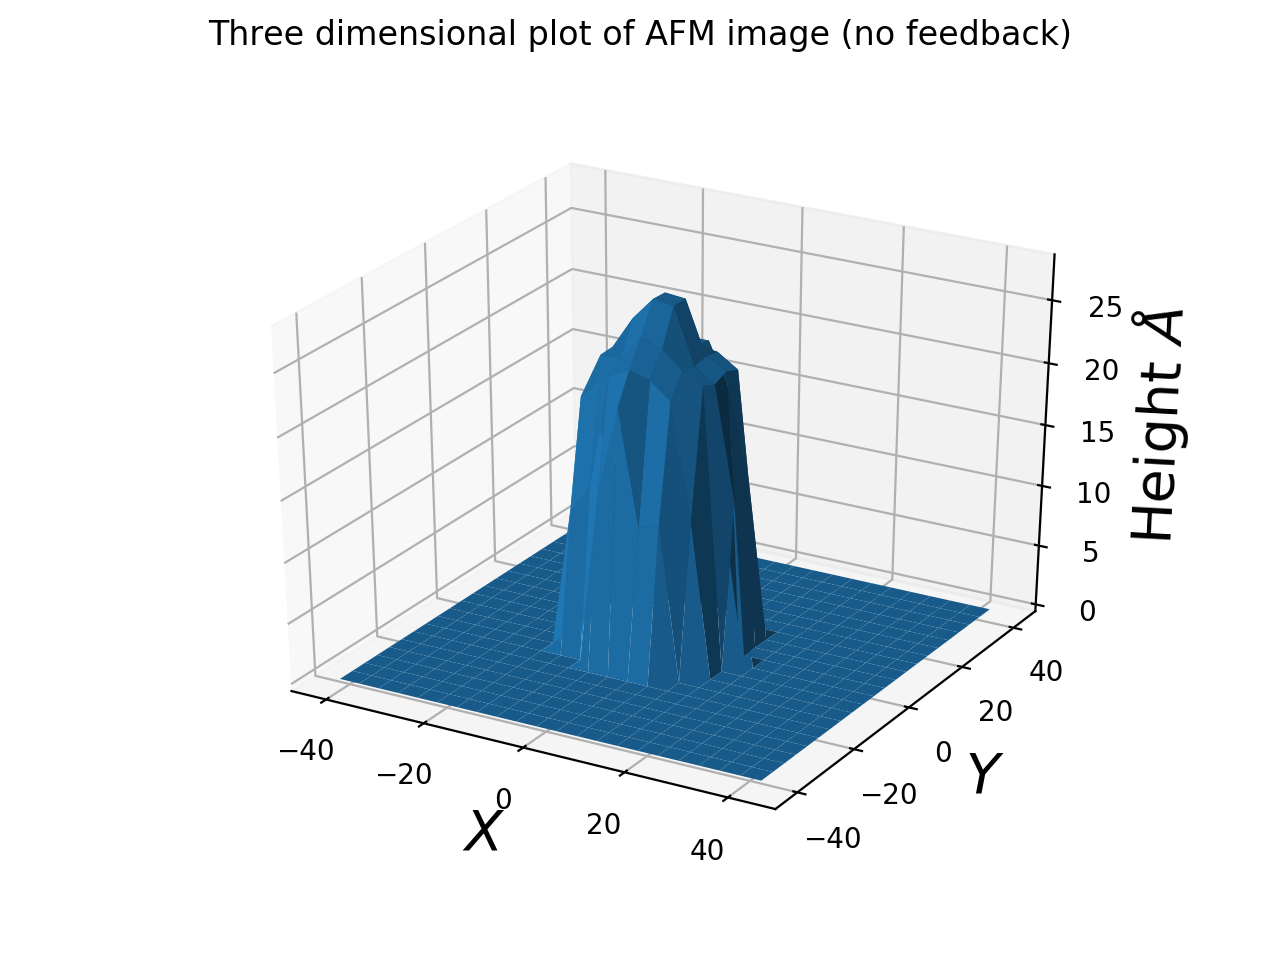

<IPython.core.display.Javascript object>


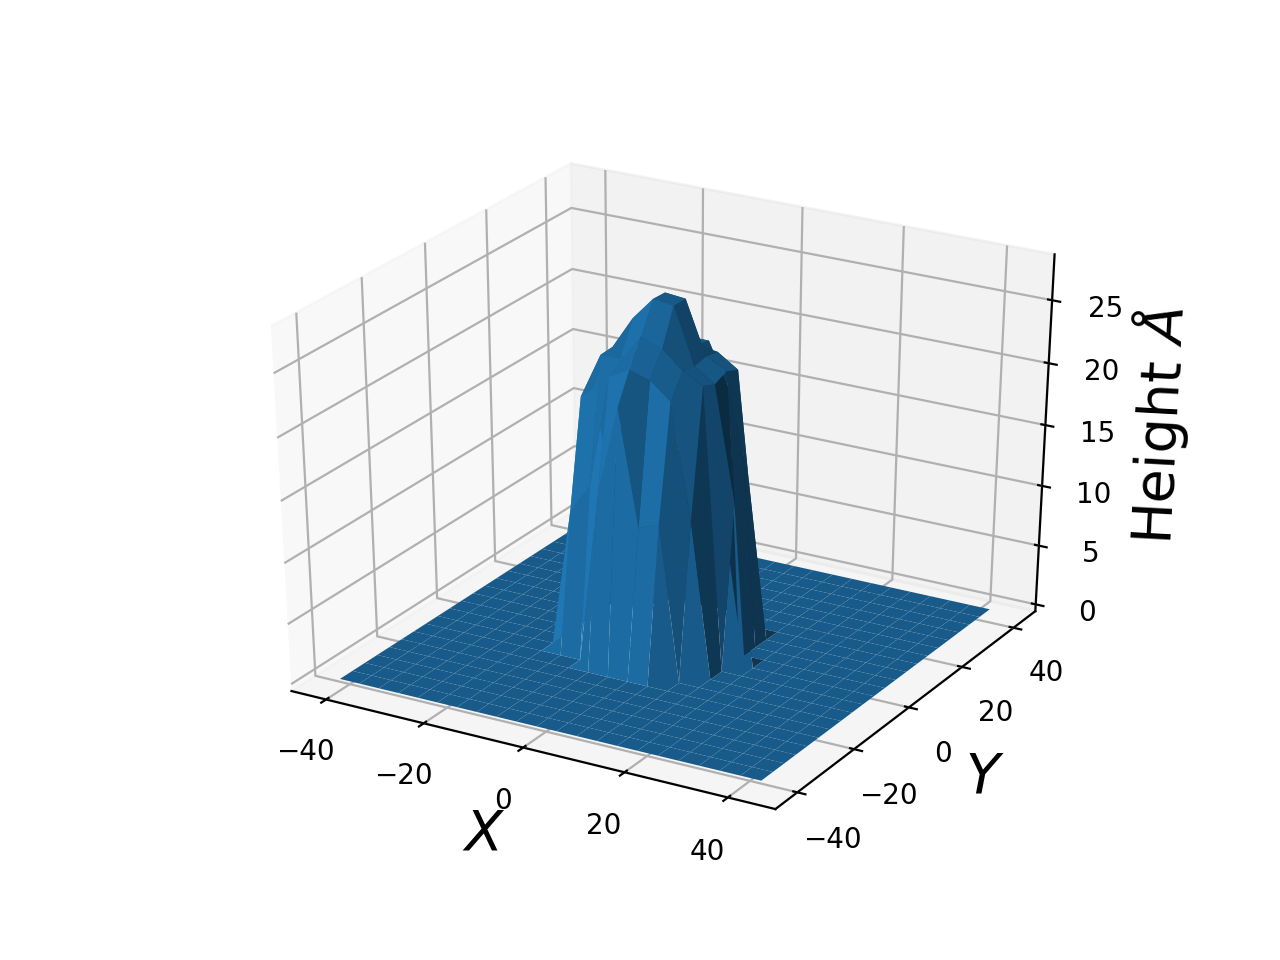

<IPython.core.display.Javascript object>


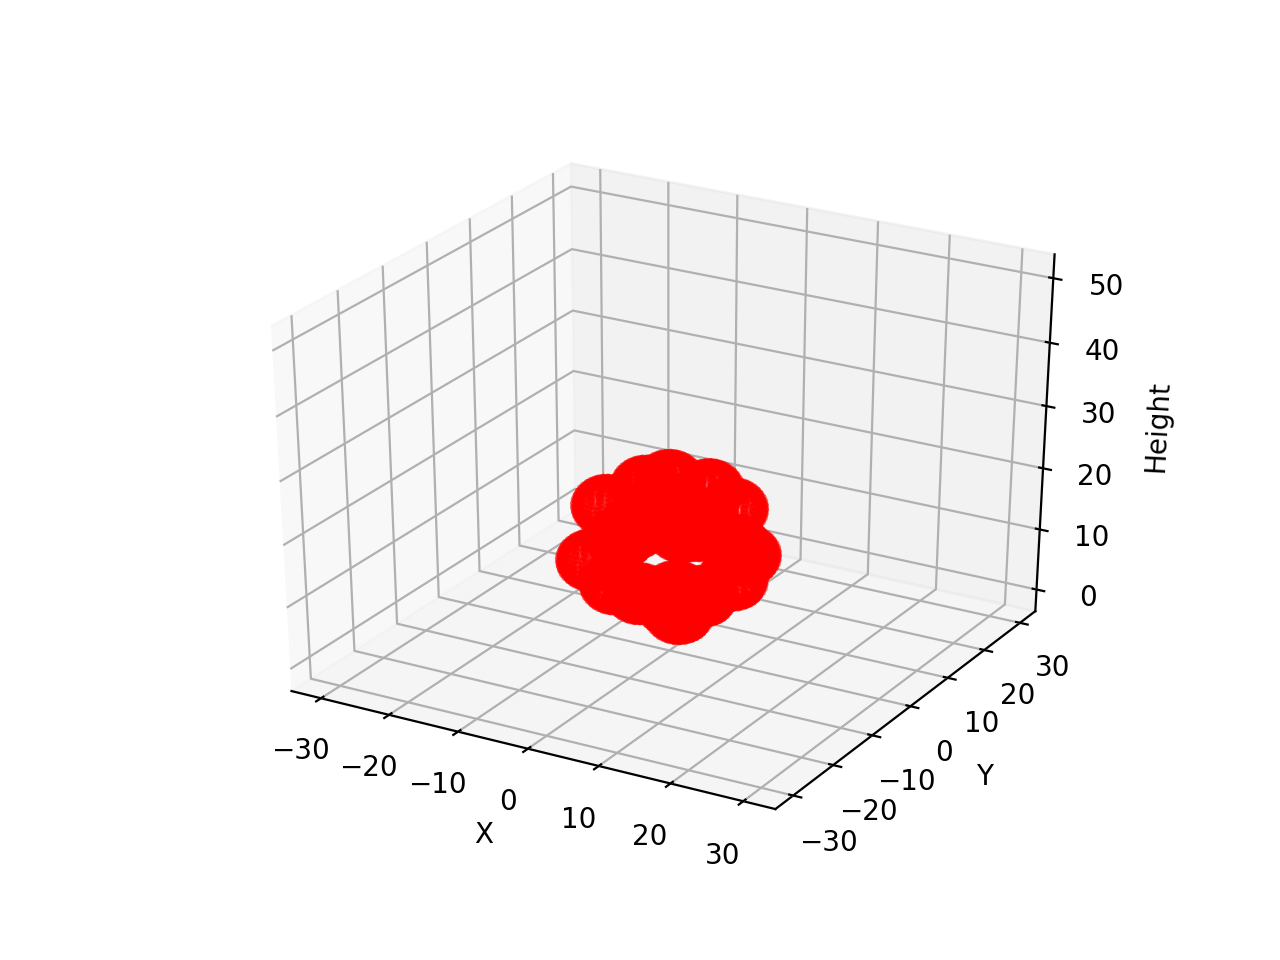

<IPython.core.display.Javascript object>


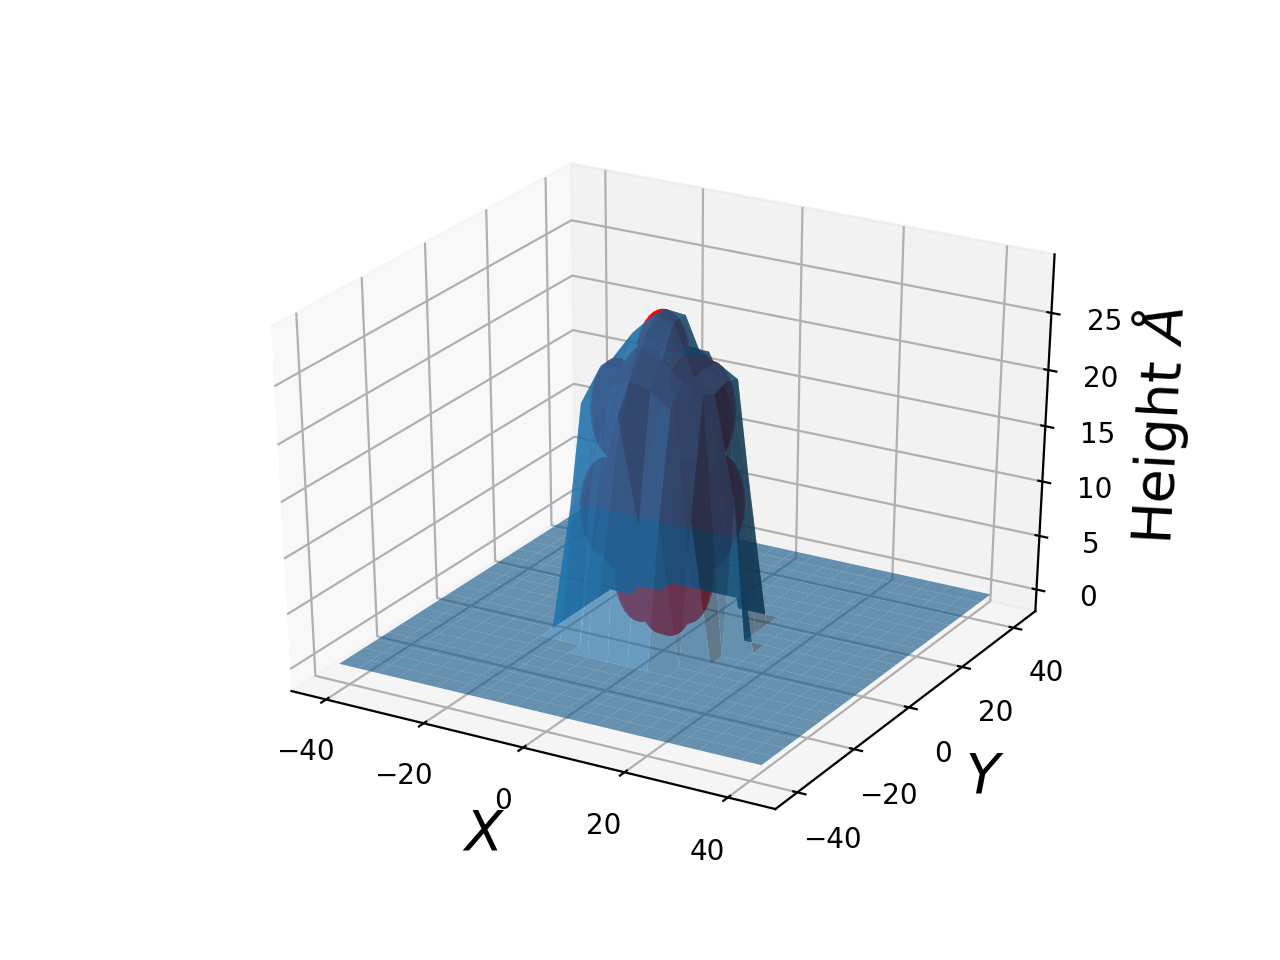

<IPython.core.display.Javascript object>


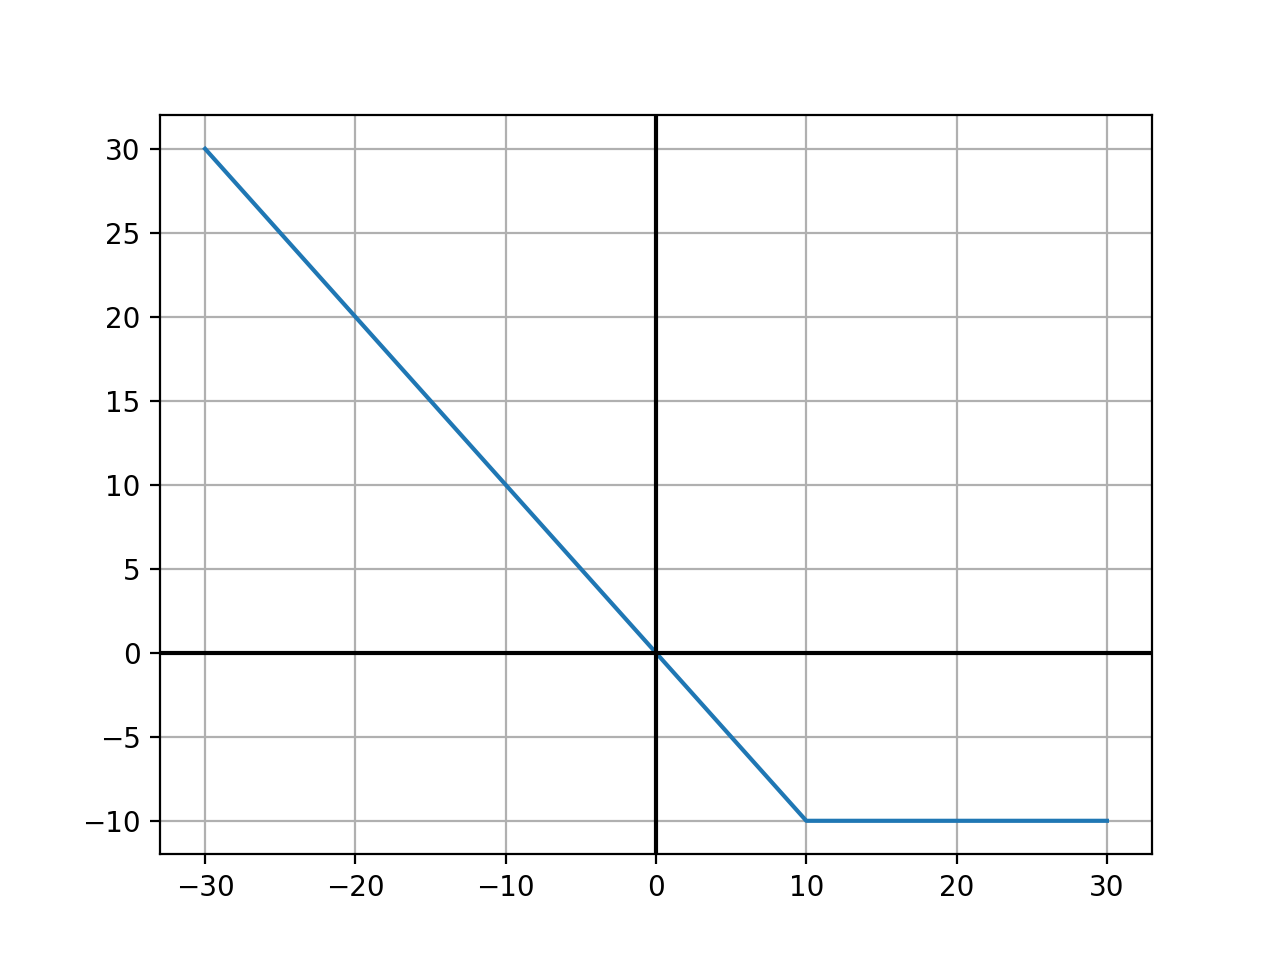

         15141125 function calls (15134547 primitive calls) in 12.315 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002   12.316   12.316 <ipython-input-37-2dc604f78b56>:1(psuedo_AFM_image_producer)
        1    0.015    0.015   11.661   11.661 <ipython-input-12-695533d0234c>:1(height_image_producer)
      484    0.249    0.001   11.630    0.024 <ipython-input-36-4e131b9ee669>:3(height_diff_calc_three_dee)
   235224    0.378    0.000    8.442    0.000 /opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:868(__getitem__)
   235224    0.633    0.000    7.935    0.000 /opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/multi.py:1473(get_value)
   235224    0.099    0.000    6.081    0.000 /opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/multi.py:1478(_try_mi)
   235224    0.202    0.000    5.981    0.000 /opt/anaconda3/lib/python3.7/site-packages/pandas/core/inde

0

In [38]:
#Using the final function and user inputs to create final results 
import time


#t0 = time.time()

psuedo_AFM_image_producer(structure1,r=1,theta_in_degrees=2,xstep=4,ystep=4, extension = 30, x_rot = 0, y_rot = 0,z_rot = 0, noise_strength = 0, noise_mean = 3,noise_variance = 0.5, setpoint = 0 ,arb = 10 ,KP_eff = 0.4 , KI = 0.6 ,n=1, grad = 1, scanline_direction='both',ThreeDplot = True, Feedbacked = True, Heatmap = True, molecule_view = True, view_style = 'spacefill', Simulated_Surface = True, DotPlot = True,Overlay_Plot=True, relative_contrast = 0.0, feedback_graph = True)
 
#t1 = time.time()
#total = t1-t0


## The following section was used to investigate the efficiency of the code 

In [28]:
import cProfile, pstats, io



def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner